In [51]:
# Custom round robin

import random
import pandas as pd
from itertools import combinations, chain

import matplotlib.pyplot as plt
import numpy as np


In [52]:
countries = [
    'Argentina', 
    'Brazil', 
    'Colombia', 
    'Uraguay', 
    'Ecuador', 
    'Mexico', 
    'Panama', 
    'Morocco', 
    'Egypt', 
    'Spain', 
    'UK', 
    'Italy', 
    'France', 
    'Germany', 
    'Netherlands', 
    'Japan', 
    'South Korea', 
    "Australia", 
    'Turkey', 
    'New Zealand'
]

countriesrs = {
    'Argentina': 2140, 
    'Brazil': 1994, 
    'Colombia': 1953, 
    'Uraguay': 1922, 
    'Ecuador': 1911, 
    'Mexico': 1817, 
    'Panama': 1724, 
    'Morocco': 1807, 
    'Egypt': 1668, 
    'Spain': 2150, 
    'UK': 2012, 
    'Italy': 1914, 
    'France': 2031, 
    'Germany': 1988, 
    'Netherlands': 1967, 
    'Japan': 1875, 
    'South Korea': 1745, 
    "Australia": 1736, 
    'Turkey': 1837, 
    'New Zealand': 1596
}

countriesratings = countriesrs

# for country in countriesrs.keys():
#     rating = countriesrs[country]
    
#     countriesratings[country] = (rating - 1596)/(2150-1596)
# print(countriesratings)

In [53]:
def simulate_match(country1, country2):
    # Randomly generate results: win, loss, or draw
    # result = random.choice(['win', 'loss', 'draw'])
    
    rating1 = countriesratings[country1]
    rating2 = countriesratings[country2]
    
    percent1 = 1/(1 + 10**((rating2-rating1)/400))
    
    
    if random.random() < percent1:
        result = 'win'
    else:
        result = 'loss'
    
    if result == 'win':
        return country1, 3, country2, 0  # country1 wins, gets 3 points, country2 gets 0
    elif result == 'loss':
        return country1, 0, country2, 3  # country2 wins, gets 3 points, country1 gets 0
    else:
        return country1, 1, country2, 1  # Draw, both get 1 point each

In [54]:
def init_standings(teams):
    return {team: {'wins': 0, 'losses': 0, 'draws': 0, 'points': 0} for team in teams}

In [55]:

def round_robin(teams):
    standings = init_standings(teams)
    for team1, team2 in combinations(teams, 2):
        t1, p1, t2, p2 = simulate_match(team1, team2)
        standings[t1]['points'] += p1
        standings[t2]['points'] += p2
        if p1 == 3:
            standings[t1]['wins'] += 1
            standings[t2]['losses'] += 1
        elif p2 == 3:
            standings[t2]['wins'] += 1
            standings[t1]['losses'] += 1
        else:
            standings[t1]['draws'] += 1
            standings[t2]['draws'] += 1
    return standings


In [56]:

def sort_standings(standings):
    df = pd.DataFrame(standings).T
    df = df.sort_values(by=['points', 'wins'], ascending=False)
    return df

In [57]:

def simulate_knockout(teams):
    random.shuffle(teams)
    quarter_finalists = teams
    semi_finalists = []

    # Quarterfinals
    for i in range(0, 8, 2):
        team1, team2 = quarter_finalists[i], quarter_finalists[i+1]
        winner = simulate_match(team1, team2)[0 if random.random() < (1/(1 + 10**((countriesratings[team2]-countriesratings[team1])/400))) else 2]
        semi_finalists.append(winner)

    # Semifinals
    finalists = []
    for i in range(0, 4, 2):
        team1, team2 = semi_finalists[i], semi_finalists[i+1]
        winner = simulate_match(team1, team2)[0 if random.random() < (1/(1 + 10**((countriesratings[team2]-countriesratings[team1])/400))) else 2]
        finalists.append(winner)

    # Final
    final_winner = simulate_match(finalists[0], finalists[1])[0 if random.random() < (1/(1 + 10**((countriesratings[team2]-countriesratings[team1])/400))) else 2]
    
    return {
        "Quarterfinalists": quarter_finalists,
        "Semifinalists": semi_finalists,
        "Finalists": finalists,
        "Winner": final_winner
    }


{'Argentina': 224, 'Brazil': 78, 'Colombia': 31, 'Uraguay': 22, 'Ecuador': 12, 'Mexico': 20, 'Panama': 3, 'Morocco': 13, 'Egypt': 0, 'Spain': 247, 'UK': 94, 'Italy': 25, 'France': 72, 'Germany': 37, 'Netherlands': 33, 'Japan': 63, 'South Korea': 9, 'Australia': 5, 'Turkey': 12, 'New Zealand': 0}


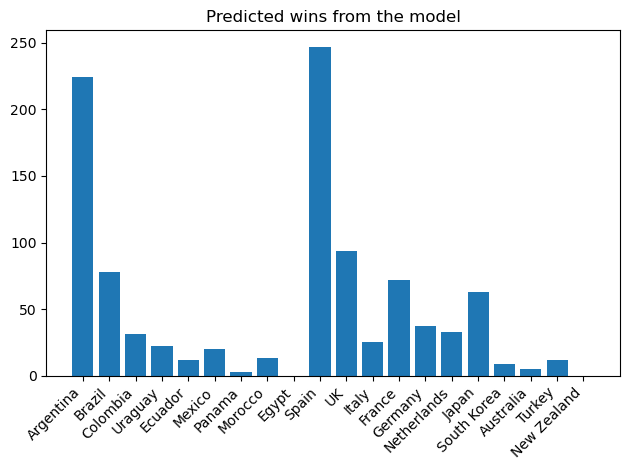

In [58]:
pools = {
    1: ['Argentina', 'Brazil', 'Colombia', 'Uraguay', 'Ecuador'],
    2: ['Mexico', 'Panama', 'Morocco', 'Egypt', 'Spain'],
    3: ['UK', 'Italy', 'France', 'Germany', 'Netherlands'],
    4: ['Japan', 'South Korea', "Australia", 'Turkey', 'New Zealand']
}

winners = {country: 0 for country in countries}

for i in range(1000):
    # Step 2: Round robin in each pool
    pool_results = {}
    top_2_from_each_pool = []
    rest_teams = []

    for pool_name, teams in pools.items():
        standings = round_robin(teams)
        pool_results[pool_name] = sort_standings(standings)
        top_2 = list(pool_results[pool_name].index[:2])
        rest = list(pool_results[pool_name].index[2:])
        top_2_from_each_pool.extend(top_2)
        rest_teams.extend(rest)

    # Step 3: Knockout Stage
    knockout_results = simulate_knockout(top_2_from_each_pool)

    # Step 4: Consolation Round Robin for remaining 12 teams
    consolation_standings = round_robin(rest_teams)
    consolation_df = sort_standings(consolation_standings)

    # Step 5: Display Results
    # Pool Results
    # for pool_name, df in pool_results.items():
    #     print(f"\n{pool_name} Standings:\n", df)

    # # Knockout
    # print("\nKnockout Results:")
    # for stage, teams in knockout_results.items():
    #     print(f"{stage}: {teams}")

    # # Consolation League Standings
    # print("\nConsolation League Standings:")
    # print(consolation_df)
    
    winners[knockout_results['Winner']] += 1

print(winners)

names = list(winners.keys())
values = list(winners.values())

plt.bar(names, values)
plt.title("Predicted wins from the model")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels and align them to the right for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

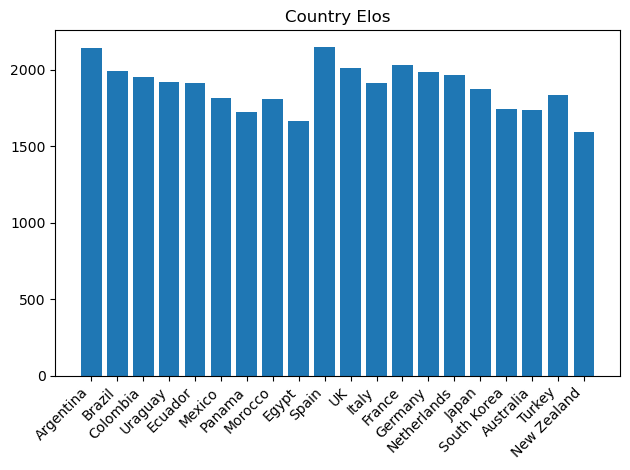

In [59]:
names = countries
values = list(countriesratings.values())

plt.bar(names, values)
plt.title("Country Elos")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels and align them to the right for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()